This notebooks replicates the [Human Protein Atlas coexpression](https://github.com/TomConlin/human_protein_atlas_coexpression) notebook but with BGEE expression data in hopes of finding co expression profile matches for FA genes.

Input is filtered to remove `'absent'` and `'bronze quality'`.

expression  
 - present (5,991,306 
 - absent (2,893,316  skipped)
 
quality  
 - gold    (2,921,827)
 - silver  (5,837,817)
 - bronze    (124,978   skipped)  

grep "present" Homo_sapiens_expr_simple.tsv | grep -v "bronze quality" > Homo_sapiens_expr_present.tsv

`absent` is removed because of the number of connections it promotes. 
Basicly every gene becomes associated with many thousands (about 10% of the gnome)   
My guess is there are more ways for expression to be reported absent than preaent.

`bronze` is removed because after days of running and rerunning 
this process I 

#### Take N+1  

Since we are longer keping absent calls we don't need to handle three states
will no longer need to multiply or dot product.  

Also means the the number of nonzeros in either of the comparison pair is an insufficent benchmark  and the number of non zeros in the combined pair is  the value to compare with the benchmark so...  
the benchmark has to be something like the average number of non zeros in the pair

score = 2*nz(a&b)/nz(a)+nz(b)

Only keeping pairs with __perfect__ agreement (non-disagrement)
resulted in only about 8k out of 60k ENSG being associated into about 1350 clusters.  

Allowing a tiny amount of wiggle room in number of tissues with reported expression 
will improve coverage.


```
ENSG00000000003
ENSG00000000005
ENSG00000000419
ENSG00000000457
ENSG00000000460
ENSG00000000938
ENSG00000000971
ENSG00000001036
ENSG00000001084
ENSG00000001167
```



In [6]:
import csv
import re
import array
import matplotlib.pyplot as plt
import statistics
import requests
import json
import yaml
import os
import networkx as nx
from networkx.algorithms import approximation
import datetime
import operator

Use the tissue measurement frequency to set the order for tissue profile recording  
this file was generated in the explore notebook

In [2]:
file = 'tissue_count_present.tab' 
# count tissue_id
tissue_index = {}
with open(file, newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter='\t')
    #csvreader.__next__()  # header
    line_number = 0
    for line in csvreader:
        (count, tissue_id) = line
        tissue_index[tissue_id] = line_number
        line_number += 1
tissue_length = len(tissue_index)     

In [4]:
print('how many tissues: ', tissue_length)

how many tissues:  308


In [5]:
file = 'Homo_sapiens_expr_present.tsv'
#1:Gene ID
#2:"Gene name"
#3:Anatomical entity ID
#4:"Anatomical entity name"
#5:Expression
#6:Call quality
#7:Expression rank

# make places to stash stuff 
gene_tissue = {}
#gene_tissue_rank_curve = {}
tissue_names = {}
gene_names = {}

with open(file, newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter='\t', quotechar='"')
    # csvreader.__next__()  # no header on filtered file
    for line in csvreader:
        (gene_id, gene_name, tissue_id, tissue_name, level, reliability, rank) = line
        # record the measurement   
        if gene_id in gene_tissue:
            gene_tissue[gene_id][tissue_index[tissue_id]] = 1
        else:
            gene_tissue[gene_id] = array.array('b', [0] * tissue_length)
            gene_tissue[gene_id][tissue_index[tissue_id]] = 1

        # save human friendly tissue label 
        if tissue_id not in tissue_names:
            tissue_names[tissue_id] = tissue_name
        
        # save human friendly gene symbol 
        if gene_id not in gene_names:
            gene_names[gene_id] = gene_name

In [6]:
len(gene_tissue)

59166

In [7]:
# a couple of arbitrary particulars
g1 = 'ENSG00000000003' 
g2 = 'ENSG00000001167'

# how many tissues are both genes expressed in together
sum([a&b for (a,b) in zip(gene_tissue[g1],gene_tissue[g2])])

247

In [8]:
# # how many tissues are both genes expressed in separately
sum(gene_tissue[g1])+sum(gene_tissue[g2])  

512

In [9]:
# relative score
2*sum([a&b for (a,b) in zip(gene_tissue[g1],gene_tissue[g2])])/(sum(gene_tissue[g1])+sum(gene_tissue[g2]))

0.96484375

In [10]:
# absolute score
sum([a&b for (a,b) in zip(gene_tissue[g1],gene_tissue[g2])])/len(gene_tissue[g1])

0.801948051948052

In [11]:
# save a copy 
with open('gene_tissue_present.yaml', 'w') as fh:
    yaml.dump(gene_tissue, fh)

Make a record of how many tissues each gene is expressed in 
and look at the distrabution. 

Do any genes have too few tissues?

In [12]:
gene_tissue_count = {}
for gene in gene_tissue:
   gene_tissue_count[gene] = sum(gene_tissue[gene])

In [13]:
# save a copy 
with open('gene_tissue_count.yaml', 'w') as fh:
    yaml.dump(gene_tissue_count, fh)

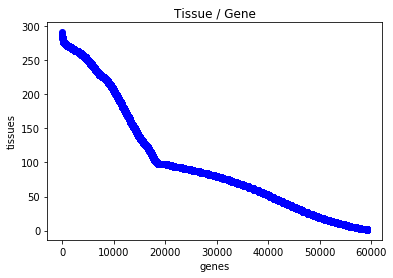

In [27]:


# https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_degree_rank.html#sphx-glr-auto-examples-drawing-plot-degree-rank-py
plt.plot(sorted(gene_tissue_count.values(), reverse=True), 'b-', marker='o')
plt.title("Tissue / Gene")
plt.ylabel("tissues")
plt.xlabel("genes")
plt.show()

In [30]:
print("Mean:\t", statistics.mean(gene_tissue_count.values()))
print("Mode:\t", statistics.mode(gene_tissue_count.values()))
print("Median:\t", statistics.median(gene_tissue_count.values()))
print("StdDev:\t", statistics.pstdev(gene_tissue_count.values()))

Mean:	 99.15032282053882
Mode:	 98
Median:	 80.0
StdDev:	 80.05983981161485


In [ ]:
genes = list(gene_tissue) # need a fixed order
genlen = len(genes)
gtlen = len(gene_tissue[genes[1]])

print("number of ensembl genes: ", genlen)
print("total number of tissues: ", gtlen)
print(genes[1])

# print("number of pairwise comparisons: ", (genlen^2)/2-genlen)

Overflows

(59166^2)÷2−59166 == 1,750,248,612

~1.75  billion comparisons  
comb pairs of vectors with over 300 values each


maybe I should switch to Julia for this next part.

  - with plain python a thousand sweeps of the genome is about 40 minutes
   - about a day though I neve let it run more than a few thouand sweeps
   
  - with numpy the first thousand sweeps of the genome is about 6 minutes
   - 2.5 to 3 hours; I ran these too many times
   
  - Julia is under 2 minutes for the first thousand sweeps  
   - 45 minutes total
 
Yep. Should have switched sooner.


#### Python
Runs in about a day
```
for a in range(0,genlen-1):
    a_name = genes[a]
    a_len = sum(gene_tissue[a_name])
    if 0 == a%1000:
        print(str(a) + ' kept ' + str(len(pairwise_common)) +  " " + str(datetime.datetime.now()))      
    for b in range(a+1, genlen):
        together = sum([a&b for (a,b) in zip(gene_tissue[a_name], gene_tissue[genes[b]])])
        separate = a_len + sum(gene_tissue[genes[b]])
        if 2 * together == separate:
            pairwise_common[a_name + ',' + genes[b]] = together

print(str(genlen) + ' kept ' + str(len(pairwise_common)) +  " " + str(datetime.datetime.now()))
```

#### Julia
Runs in about 45 minutes
```
for a in 1:genlen-1
    a_name = genes[a]
    a_len = sum(gene_profile[a_name])
    if 0 == a % 1000
        println(a, "\t", now())  
    end    
    for b in a+1:genlen
        together = sum(gene_profile[a_name] & gene_profile[genes[b]])
        separate = a_len + sum(gene_profile[genes[b]])
        if 2 * together == separate
            pairwise_common[a_name => genes[b]] = together
        end
    end                
end
println(genlen,"\t", now())
```

===========================================================================

In [149]:
# import the graph Julia wrote out
G = nx.Graph()
  
with open("gene_gene_tissues.tab") as fh:
    reader = csv.reader(fh, delimiter='\t')
    for row in reader:
        (g1,g2,tcnt)  = row
        G.add_edge(row[0], row[1],weight=row[2])   

In [150]:
clusters = nx.connected_components(G)

In [151]:
print(nx.number_connected_components(G))

710


In [ ]:
# approximation.k_components(G); # does not return

In [152]:
# dont try one with too many edges
G.neighbors('ENSG00000228064')

['ENSG00000248711', 'ENSG00000248195', 'ENSG00000227988', 'ENSG00000231137']

In [94]:
 # nx.average_degree_connectivity(G)

In [95]:
 # nx.average_neighbor_degree(G)

In [153]:
# write out cluster each gene is in
gene_cluster = {}
clust = 0
for cluster in clusters:
    clust += 1
    for node in cluster: 
        gene_cluster[node] = clust

In [154]:
gene_cluster['ENSG00000140740']

6

In [155]:
with open('ensg_cluster.yaml', 'w') as fh:
    yaml.dump(gene_cluster, fh)

In [156]:
degree_sequence = sorted(G.degree().items(), key=operator.itemgetter(1), reverse=True)
# sorted(x.items(), key=operator.itemgetter(1))

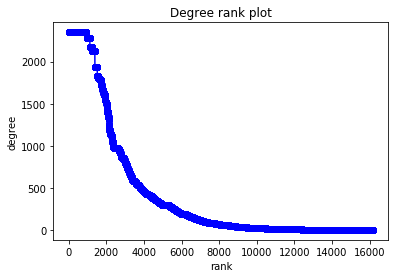

In [157]:
# adapted from: 
# https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_degree_rank.html#sphx-glr-auto-examples-drawing-plot-degree-rank-py
plt.plot([d for n,d in degree_sequence], 'b-', marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

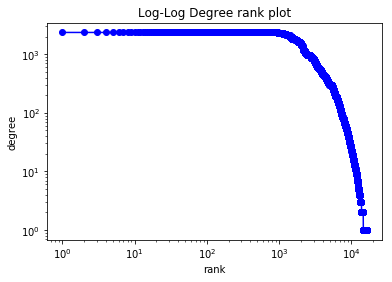

In [158]:
plt.loglog([d for n,d in degree_sequence], 'b-', marker='o')
plt.title("Log-Log Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

In [159]:
! tr ',' '\n'  < ensg_cluster.yaml | grep -v "^$" | tr -d "} {" | tr ':' '\t' | sort -k2,2n >  ensg_cluster.tab

In [160]:
! cut -f2 ensg_cluster.tab | uniq -c | sort -nr | head -20

   7353 1
   3979 6
   1222 5
    296 4
    279 13
    190 26
     83 9
     79 7
     62 59
     58 31
     55 17
     41 54
     41 2
     35 64
     29 47
     28 95
     26 37
     25 131
     24 130
     23 35
sort: write failed: 'standard output': Broken pipe
sort: write error


##### It looks like there a few thousand that have a degree of a few thousand.

A thousand associations is probably in the diminishing returns catagory for human cognition.

With any luck they are all pointing at each other. (they really have to be)

So maybe we will end up dropping the few most populated clusters  (1, 5 & 6)


In [161]:
# how many genes made it into some cluster
! wc -l ensg_cluster.tab

16184 ensg_cluster.tab


12.4k out of 60k means about 27% of the input found some sort of coexpression relation

lets hope our FA genes are in there this time

In [162]:
concordant = sorted([int(row.split(" ")[2]) for row in nx.generate_edgelist(G,data=['weight'])], reverse=True)

In [163]:
# 
concordant[0:9]
#(g1,g2,w) = next(nx.generate_edgelist(G,data=['weight'])).split(' ') ; w

[284, 284, 283, 283, 283, 283, 283, 283, 283]

In [165]:
print("Min:\t", min(concordant))
print("Max:\t", max(concordant))
print("Mean:\t", statistics.mean(concordant))
print("Median:\t", statistics.median(concordant))
print("Mode:\t", statistics.mode(concordant))
print("StdDev:\t", statistics.pstdev(concordant))

Min:	 1
Max:	 284
Mean:	 127.52173552660332
Median:	 97.0
Mode:	 96
StdDev:	 68.7375400624874


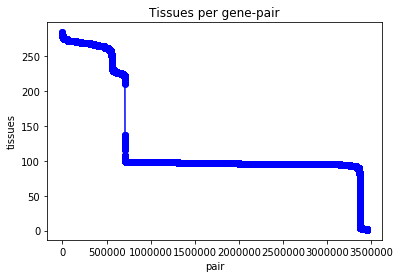

In [166]:
plt.plot(concordant, 'b-', marker='o')
plt.title("Tissues per gene-pair")
plt.ylabel("tissues")
plt.xlabel("pair")
plt.show()

I would not be suprised to learn duplex 7X7 well plates were common in expresion wetlabs.

### Fanconi Genes

In [7]:
def fa_reader(fa_filename, fa_dict):
    
    with open(fa_filename, 'r') as fh:
        reader = csv.reader(fh, delimiter='\t')
        for row in reader:
            (ncbi_gene, symbol) = row
            fa_dict[ncbi_gene] = symbol

    return fa_dict

In [8]:

fa_core = fa_reader("FA_1_core_complex.txt", {})

{'NCBIGene:2175': 'FANCA',
 'NCBIGene:2176': 'FANCC',
 'NCBIGene:2177': 'FANCD2',
 'NCBIGene:2178': 'FANCE',
 'NCBIGene:2187': 'FANCB',
 'NCBIGene:2188': 'FANCF',
 'NCBIGene:2189': 'FANCG',
 'NCBIGene:29089': 'UBE2T',
 'NCBIGene:55120': 'FANCL',
 'NCBIGene:55215': 'FANCI',
 'NCBIGene:57697': 'FANCM'}

In [9]:

fa_effector = fa_reader("FA_2_effector_proteins.txt", {})

fa_associated = fa_reader("FA_3_associated_proteins.txt", {})

In [11]:
fa_symbol = {}
fa_reader("FA_1_core_complex.txt", fa_symbol)
fa_effector = fa_reader("FA_2_effector_proteins.txt", fa_symbol)
fa_associated = fa_reader("FA_3_associated_proteins.txt", fa_symbol)

###  HGNC_nomenclature_update 
(Read files files produced from external notebook)

In [13]:
with open('ensgid_symbol_hgnc.yaml', 'r') as fh:
    ensg_sym = dict(yaml.load(fh))
    
with open('ncbi_symbol_hgnc.yaml', 'r') as fh:
    ncbi_sym = dict(yaml.load(fh))   
    
with open('ensg_ncbi.yaml', 'r') as fh:
    ensg_ncbi = dict(yaml.load(fh))

#### check FA nomemclature

In [136]:
for key in fa_symbol:
    (pfx, gid) = key.split(":")
    if gid not in ncbi_sym:
        print("Warn ", key, " not in HGNC") 
    elif fa_symbol[key] != ncbi_sym[gid]:
        print("Warn ", key ,fa_symbol[key] , ncbi_sym[gid]) 

# all okay 2017 Oct 11        

need a map in the opposite direction than we have to 
translate ncbi to ensg which we need to query the graph with FA

In [138]:
len(set(ensg_ncbi.keys()))

36860

In [139]:
len(set(ensg_ncbi.values()))

36860

In [14]:
# we are in luck this map is one to one
ncbi_ensg = dict((v, k) for k, v in ensg_ncbi.items())

#### See FA hits exist

In [1]:
# given a list of genes return associations for each
def neighborhood_watch(gene_curie_list): 

    for key in gene_curie_list:
            (pfx, gid) = key.split(":")
        if gid in ncbi_ensg:
            if ncbi_ensg[gid] in G:
                print(fa_symbol[key] + '  ')
                for neighbor in G.neighbors(ncbi_ensg[gid]):
                    print('  -[', ensg_sym[neighbor], '](http://www.ncbi.nlm.nih.gov/gene/' + ensg_ncbi[neighbor]+')  ')
            else:
                 # print("Warn ", key ,"\tmaps to ", ncbi_ensg[gid], " finds no coexpression")
                 continue
        else:
            print("Warn ", key ,"\tis not mapped to ENSG")

IndentationError: unindent does not match any outer indentation level (<ipython-input-1-37a69b02f463>, line 6)

In [ ]:
# hits on FA genes
neighborhood_watch(fa_core)

neighborhood_watch(fa_effector)

neighborhood_watch(fa_associated)

FANCG  
  -[ PLEKHJ1 ](http://www.ncbi.nlm.nih.gov/gene/55111)  
  -[ RABGEF1 ](http://www.ncbi.nlm.nih.gov/gene/27342)  
  -[ MAN2B1 ](http://www.ncbi.nlm.nih.gov/gene/4125)  
FAAP20  
  -[ ATAD3B ](http://www.ncbi.nlm.nih.gov/gene/83858)  
  -[ MCRIP2 ](http://www.ncbi.nlm.nih.gov/gene/84331)  
FANCL  
  -[ CEP170B ](http://www.ncbi.nlm.nih.gov/gene/283638)  
  -[ CCDC93 ](http://www.ncbi.nlm.nih.gov/gene/54520)  
  -[ TSPYL4 ](http://www.ncbi.nlm.nih.gov/gene/23270)  
  -[ DSTYK ](http://www.ncbi.nlm.nih.gov/gene/25778)  
  -[ MTMR4 ](http://www.ncbi.nlm.nih.gov/gene/9110)  
  -[ NAB1 ](http://www.ncbi.nlm.nih.gov/gene/4664)  
  -[ HECTD4 ](http://www.ncbi.nlm.nih.gov/gene/283450)  

In [15]:
# Quick&Dirty ensembl ids for fagenes for external checks 
for key in fa_symbol:
    (pfx, gid) = key.split(":")
    if gid in ncbi_ensg:
         print(ncbi_ensg[gid])

ENSG00000168411
ENSG00000181544
ENSG00000112039
ENSG00000185504
ENSG00000083093
ENSG00000140525
ENSG00000188827
ENSG00000175595
ENSG00000136492
ENSG00000158169
ENSG00000221829
ENSG00000131944
ENSG00000139618
ENSG00000162585
ENSG00000175279
ENSG00000187741
ENSG00000115392
ENSG00000169689
ENSG00000116670
ENSG00000012048
ENSG00000051180
ENSG00000144554
ENSG00000187790
ENSG00000077152
ENSG00000183161
ENSG00000108384
ENSG00000196584


In [ ]:
# update gene symbols

for gene_id in gene_tissue:
      # try to bring gene info up to date
        if gene_id in ensg_sym and gene_name != gene_names[gene_id]:
            print('NOTE: '+ ensg_sym[gene_id]+ ' is replacing ' + gene_names[gene_id] + ' b/c ' + gene_id)
            gene_names[gene_id] = ensg_sym[gene_id]
        elif gene_id in ensg_ncbi and ensg_ncbi[gene_id] in ncbi_sym \
                and  gene_names[gene_id] != ncbi_sym[ensg_ncbi[gene_id]]:
            print('NOTE: '+ ncbi_sym[ensg_ncbi[gene_id]] + ' is replacing ' + gene_name + ' b/c ' + gene_id + ' -> ' + ensg_ncbi[gene_id])
            gene_names[gene_id] = ncbi_sym[ensg_ncbi[gene_id]]


  !# Try to find NCBIGene_id for Ensenbl_ID
        # try to convert ids from ensembl to ncbi 
        gene_id = ensg_ncbi[gene_id] if gene_id in ensg_ncbi else gene_id

        !# last gasp conversion based on gene symbol
        if gene_id == ensg and gene_name in sym_ncbi:
            # print('WARN: ' + sym_ncbi[gene_name] + ' is replacing '+ ensg + ' b/c '+ gene_name)
            gene_id = sym_ncbi[gene_name]